In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from random import uniform
import numpy as np
from numpy import random, pi, array
import swarms
import pread as pds
from random import randint, seed, uniform

In [2]:
Mmoon = 7.35e22
Mjup = 1.898e27
Rjup = 7.1492e7
AU = 1.496e11
Rearth = 6.3781e6
Mearth = 5.972e24
pc = 3.086e16
Msun = 1.989e30
Lsun = 3.828e26
Year = 3.154e7 # seconds
KM = 1e3
MICRON = 1e-6

In [3]:
def loguniform(minval, maxval):
    return 10**uniform(np.log10(minval), np.log10(maxval))

def star_samplerM(mean=2., std=1.):
    '''
    Mstar = None
    Lstar = None
    Tstar = None
    dpl = None
    
    sample = int(random.normal(loc=mean, scale=std))
    sampled_type = 'M' + str(sample)
    for i in range(len(GPI['S_Type'])):
        if sampled_type in GPI['S_Type'][i]:
            Tstar = GPI['Teff'][i]
            Lstar = GPI['Lum'][i]*Lsun
            Mstar = GPI['Mass'][i]*Msun
            dpl = GPI['Distance_distance'][i]*pc
            break
    '''
    # Table 1 (KALTENEGGER & TRAUB) https://arxiv.org/ftp/arxiv/papers/0903/0903.3371.pdf
    ML = [7.2/100., 3.5/100., 2.3/100., 1.5/100., 0.55/100., 0.22/100., 0.09/100., 0.05/100., 0.03/100., 0.015/100.]
    MM = [0.60, 0.49, 0.44, 0.36, 0.20, 0.14, 0.10, 0.09, 0.08, 0.075]
    MT = [3800, 3600, 3400, 3250, 3100, 2800, 2600, 2500, 2400, 2300]
    sample = -1
    while sample < 0 or sample > 9:
        sample = int(random.normal(loc=mean, scale=std))
    
    return swarms.Star(M=MM[sample]*Msun, L=ML[sample]*Lsun, T=MT[sample], d=0) # M star    

def distance_sampler(mean, std):
    s = 0
    while s <= 0:
        s = random.normal(loc=mean, scale=std)
    return s

def draw_planet(star, age, IWA=0.2, OWA=1.2):
    Mmin = 21 # Mearth (Nep)
    Mmax = 5*318 # Mearth (Jup)
    # Draw mass from Nep to 13 Mjup according to m^-0.86 Clanton 16
    totoccurrence = 1.
    Npts = 1000
    alpha = -0.86
    Q = 0.5 # planet albedo
    ms = np.linspace(Mmin, Mmax, Npts)
    pdf = ms**(alpha-1) # dN/dlogM = dN/dM * m, so dN/dM \propto m^(alpha-1)
    cumpdf = np.cumsum(pdf)/pdf.sum() * totoccurrence
    randv = np.random.uniform()
    idx = np.searchsorted(cumpdf, randv)
    if idx == len(cumpdf):
        return None # didn't draw a planet
    else:
        # draw semimajor axis
#         amin = star.d/pc*IWA# AU
#         amax = star.d/pc*OWA # AU
        amin = 0.01 # AU
        amax = 200 # AU
        a = loguniform(amin, amax)
        print("a in notebook: {0:.3e}".format(a))
        return swarms.Planet(star, M=ms[idx]*Mearth , R=None, a=a*AU, Q=Q, Z='002', age=age)

def inverse_cdf(y):
    A = -0.785
    B = 0.603
    return 10**((y - A)/B)  

def age_sampler():
    y = uniform(0, 1)
    age = inverse_cdf(y)
    if age > 100:
        return age_sampler()
    return age*1e6 * Year

def computeQd(D, rho, fQ):
    """Compute the planetesimal strength of an object."""
    return 0.1*rho*(D/KM)**1.26/fQ

In [4]:
def aoptChar(Mstar, Mtot, tage):
    star = swarms.Star(Lsun, Mstar, 6000, d=0)
    planet = draw_planet(star, tage)
    if planet is None:
        return aoptChar(Mstar, Mtot, tage) # do it again
    Dc = loguniform(1e4, 1e6) # m
    rho = 1000 # kg/m^3
    eta = 0.5 # eta
    Dt = loguniform(10, 1000) # m
    Nstr = 6
    Dmax = Dc
    fQ = loguniform(1,10)
    f_vrel = 4./pi
  
    return aopt11(star, Mtot, 1e6*Year, planet, Dt, Nstr, fQ, Dc, rho, eta, charFactor=1., f_vrel=4./pi)
#     part1 = (Mstar/Msun)**0.33 * f_vrel**0.55
#     part2 = (planet.M/Mearth)**0.06 * computeQd(Dc, rho, fQ)**0.15 * eta
#     #part3 = tage / (Year) * Mtot/Mearth / rho / (Dc/KM)
#     part3 = tage / (1e6*Year) * Mtot/Mearth / rho / (Dc/KM)
#     return 50. * part1 / part2 * part3**0.24 * AU

In [5]:
def aoptClean(star, Mtot, age, planet, Dt, Nstr, fQ, Dc, rho, eta, charFactor=1., f_vrel=4./pi):
    part1 = (star.M/Msun)**0.33 * f_vrel**0.55
    part2 = (planet.M/Mearth)**0.06 * computeQd(Dc, rho, fQ)**0.15 * eta
    part3 = age / (1e6*Year) * Mtot/Mearth / rho / (Dc/KM)
    return charFactor * 50. * part1 / part2 * part3**0.24 * AU

In [6]:
def aopt11(star, Mtot, age, planet, Dt, Nstr, fQ, Dc, rho, eta, charFactor=1., f_vrel=4./pi):
    return AU * charFactor * 65. * (fQ/5.)**0.15 * (eta/0.3)**(-1.) * (rho/1000.)**(-0.39) * (Dc/(KM * 100.))**(-0.43) * (planet.M/Mjup)**(-0.06) * (star.M/Msun)**0.33 * (age/(1e6*Year))**0.24 * (Mtot/Mearth)**0.24  

## Distribution of aopt given characteristic values

In [7]:
aopt = []
for i in range(500):
    aopt.append(aoptChar(Msun, Mearth, 30e6*Year)/AU)

a in notebook: 2.461e+00
a in notebook: 4.234e-02
a in notebook: 4.001e-01
a in notebook: 4.127e+01
a in notebook: 2.036e+00
a in notebook: 1.383e-02
a in notebook: 8.420e+00
a in notebook: 2.124e+00
a in notebook: 3.072e+01
a in notebook: 6.052e-01
a in notebook: 2.272e-01
a in notebook: 2.415e-01
a in notebook: 9.225e+00
a in notebook: 3.079e+00
a in notebook: 2.316e+00
a in notebook: 5.322e+00
a in notebook: 8.464e-01
a in notebook: 2.219e+01
a in notebook: 3.974e-02
a in notebook: 4.602e+00
a in notebook: 8.684e-01
a in notebook: 6.516e+00
a in notebook: 8.671e+01
a in notebook: 3.208e-02
a in notebook: 2.709e+01
a in notebook: 9.189e-02
a in notebook: 2.139e+01
a in notebook: 1.869e-02
a in notebook: 3.827e+00
a in notebook: 3.079e-01
a in notebook: 3.276e-02
a in notebook: 5.438e+00
a in notebook: 1.439e-01
a in notebook: 1.051e+00
a in notebook: 1.072e+00
a in notebook: 5.885e+01
a in notebook: 1.652e+01
a in notebook: 8.320e+00
a in notebook: 3.512e+00
a in notebook: 5.479e+00


a in notebook: 4.468e+01
a in notebook: 3.338e+01
a in notebook: 2.961e+01
a in notebook: 2.512e+01
a in notebook: 9.488e-01
a in notebook: 2.966e-01
a in notebook: 1.381e+00
a in notebook: 2.538e-01
a in notebook: 8.058e-01
a in notebook: 1.573e+01
a in notebook: 1.680e-02
a in notebook: 1.385e+01
a in notebook: 1.270e+00
a in notebook: 3.250e+01
a in notebook: 3.809e+01
a in notebook: 1.060e+00
a in notebook: 2.830e-02
a in notebook: 3.774e-02
a in notebook: 1.963e-01
a in notebook: 2.210e-01
a in notebook: 5.120e+00
a in notebook: 1.582e+02
a in notebook: 5.030e-01
a in notebook: 6.887e+00
a in notebook: 1.901e-01
a in notebook: 1.107e-02
a in notebook: 2.764e+01
a in notebook: 1.289e+01
a in notebook: 7.040e+01
a in notebook: 4.966e+00
a in notebook: 2.034e-01
a in notebook: 5.060e-02
a in notebook: 1.657e+02
a in notebook: 3.122e+01
a in notebook: 5.357e+00
a in notebook: 3.948e+01
a in notebook: 5.890e-02
a in notebook: 3.989e-01
a in notebook: 7.101e+01
a in notebook: 1.895e+02


(array([113.,  98.,  64.,  49.,  61.,  47.,  33.,  21.,   8.,   6.]),
 array([ 12.0566984 ,  23.66219754,  35.26769668,  46.87319582,
         58.47869497,  70.08419411,  81.68969325,  93.29519239,
        104.90069153, 116.50619067, 128.11168981]),
 <a list of 10 Patch objects>)

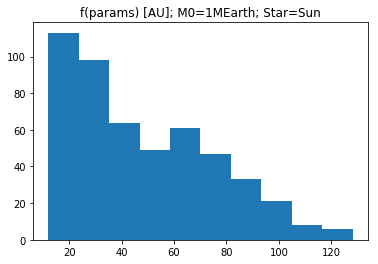

In [8]:
fig, ax = plt.subplots()
ax.set_title("f(params) [AU]; M0=1MEarth; Star=Sun")
ax.hist(aopt)

## Sampling Stars

In [9]:
def sample(M0, lamb):
    starChar = swarms.Star(Lsun, Msun, 6000, d=0)
    ageChar = 30e6*Year
    star = swarms.Star(0.072*Lsun, 0.60*Msun, 3800, d=0) # M0
    #star = swarms.Star(0.16*Lsun, 0.69*Msun, 4410, d=0) # K5
    #star.d = distance_sampler(mean=dopt-(65*pc), std=(dopt-(65*pc))/6.)
    age = age_sampler()
    
    planetChar = draw_planet(starChar, age=ageChar)
    planet = draw_planet(star, age=age)
    if planetChar is None:
        return sample(M0, lamb)
    if planet is None:
        return sample(M0, lamb) # do it again
    
    Dc = loguniform(1e4, 1e6) # m
    rho = 1000 # kg/m^3
    eta = 0.5 # eta
    Q = loguniform(0.05, 0.25) # Q_bd = [0, 0.8]
    g = loguniform(0.2, 0.8) # 0.32 https://arxiv.org/pdf/1709.00417.pdf
    Dt = loguniform(10, 1000) # m
    Nstr = 6
    Dmax = Dc
    fQ = loguniform(1,10)
    print(Dmax)
    print("planet.a in notebook: {0:.3e}".format(planet.a))
    swarm = swarms.CollSwarm(star, planet, M0, Dt, Dmax, Q=Q, eta=eta, Nstr=Nstr, 
                        rho=rho, fQ=fQ, correction=True, Dmin_min=lamb, age=age)
    
    charAopt = 0
#     charAopt = aopt11(starChar, Mearth, ageChar, planetChar, Dt, Nstr, fQ, Dc, rho, eta)
#     a_opt = aopt11(star, M0, age, planet, Dt, Nstr, fQ, Dc, rho, eta, charFactor=charAopt/AU)
    a_opt = swarm.aopt(t=age)
    if (a_opt/(AU*0.7) < 3):
        print("a_opt too small")
        return sample(M0, lamb)
    star.d = a_opt/(AU*0.7)*pc
   
    #print("charAopt = "+str(charAopt/AU)+"\t aopt = "+str(a_opt/AU))
    
    CRscatSwarm = swarm.CRscat(g)
    CRscatPlanet = planet.CRscat(g)
    CRthermalPlanet = planet.CRthermal(lamb)
    if np.isnan(CRthermalPlanet):
        CRthermalPlanet = 0
    return CRscatSwarm, CRscatPlanet+CRthermalPlanet, planet.a/AU, star.d/pc, planet.M, star.Imag(), a_opt/(AU*0.7), age, charAopt

In [10]:
%%time
seed(0)
M0 = 1e-6*Mearth
lamb = 1.65e-6
Nsamples = 300
CRscatSwarm1, CRPlanet1, a, d, Mplt, Imag, d_opt, ages, charAopt = np.zeros(Nsamples), np.zeros(Nsamples), np.zeros(Nsamples), np.zeros(Nsamples), np.zeros(Nsamples), np.zeros(Nsamples), np.zeros(Nsamples), np.zeros(Nsamples), np.zeros(Nsamples)
for i in range(Nsamples):
    CRscatSwarm1[i], CRPlanet1[i], a[i], d[i], Mplt[i], Imag[i], d_opt[i], ages[i], charAopt[i] = sample(M0, lamb)
    #print("i: "+str(i)+"  d_opt: "+str(d_opt[i]))

a in notebook: 1.299e-01
a in notebook: 1.581e+00
64545.84264762867
planet.a in notebook: 2.366e+11
Qd: 4.978e+03	 Dmax: 6.455e+04	 planet.M: 1.279e+27	 planet.a: 2.366e+11
a: 8.545e-07	 b: 1.893e+07
Rcc0: 1.861e-14
tnleft: 3.568e+14
a: 3.261e+00
Dc : 1.979e+04	 planet.M : 1.279e+27	 star.M : 1.193e+30
a in notebook: 1.781e+01
a in notebook: 4.567e+00
31696.600254424404
planet.a in notebook: 6.832e+11
Qd: 9.752e+02	 Dmax: 3.170e+04	 planet.M: 1.442e+26	 planet.a: 6.832e+11
a: 8.545e-07	 b: 1.574e+08
Rcc0: 2.238e-15
tnleft: 2.506e+16
Dc : 3.170e+04	 planet.M : 1.442e+26	 star.M : 1.193e+30
a in notebook: 1.377e+01
a in notebook: 7.344e+01
233328.54014905018
planet.a in notebook: 1.099e+13
Qd: 2.359e+04	 Dmax: 2.333e+05	 planet.M: 6.507e+26	 planet.a: 1.099e+13
a: 8.545e-07	 b: 1.188e+15
Rcc0: 2.965e-22
tnleft: 4.740e+20
Dc : 2.333e+05	 planet.M : 6.507e+26	 star.M : 1.193e+30
a in notebook: 2.900e+01
a in notebook: 2.291e+00
10668.00966126737
planet.a in notebook: 3.427e+11
Qd: 4.239e+0

a in notebook: 3.352e+00
a in notebook: 1.092e-02
20046.859552080787
planet.a in notebook: 1.634e+09
Qd: 2.006e+03	 Dmax: 2.005e+04	 planet.M: 1.723e+26	 planet.a: 1.634e+09
a: 8.545e-07	 b: 2.442e-03
Rcc0: 1.442e-04
tnleft: 1.537e+06
a: 1.362e+07
Dc : 1.472e-03	 planet.M : 1.723e+26	 star.M : 1.193e+30
a in notebook: 5.067e-02
a in notebook: 1.672e+02
37936.888424428056
planet.a in notebook: 2.501e+13
Qd: 3.248e+03	 Dmax: 3.794e+04	 planet.M: 2.192e+26	 planet.a: 2.501e+13
a: 8.545e-07	 b: 1.275e+15
Rcc0: 2.762e-22
tnleft: 1.184e+23
Dc : 3.794e+04	 planet.M : 2.192e+26	 star.M : 1.193e+30
a in notebook: 1.613e-02
a in notebook: 5.921e-02
111198.89289575574
planet.a in notebook: 8.858e+09
Qd: 1.457e+04	 Dmax: 1.112e+05	 planet.M: 1.035e+27	 planet.a: 8.858e+09
a: 8.545e-07	 b: 7.819e+01
Rcc0: 4.504e-09
tnleft: 2.883e+08
a: 1.922e+05
Dc : 5.786e-01	 planet.M : 1.035e+27	 star.M : 1.193e+30
a in notebook: 8.094e+01
a in notebook: 1.093e+00
480503.62151257216
planet.a in notebook: 1.635e+

a in notebook: 1.581e-02
a in notebook: 3.705e-02
10992.570036013869
planet.a in notebook: 5.542e+09
Qd: 5.768e+02	 Dmax: 1.099e+04	 planet.M: 3.693e+26	 planet.a: 5.542e+09
a: 8.545e-07	 b: 1.138e-01
Rcc0: 3.095e-06
tnleft: 4.342e+08
a: 2.423e+05
Dc : 4.537e-02	 planet.M : 3.693e+26	 star.M : 1.193e+30
a in notebook: 6.544e-01
a in notebook: 5.490e+00
14760.850771101273
planet.a in notebook: 8.214e+11
Qd: 2.601e+03	 Dmax: 1.476e+04	 planet.M: 1.536e+26	 planet.a: 8.214e+11
a: 8.545e-07	 b: 2.954e+08
Rcc0: 1.192e-15
tnleft: 4.657e+17
Dc : 1.476e+04	 planet.M : 1.536e+26	 star.M : 1.193e+30
a in notebook: 6.230e-01
a in notebook: 1.355e+01
43786.67883527224
planet.a in notebook: 2.027e+12
Qd: 1.312e+03	 Dmax: 4.379e+04	 planet.M: 1.723e+26	 planet.a: 2.027e+12
a: 8.545e-07	 b: 2.441e+10
Rcc0: 1.443e-17
tnleft: 1.474e+18
Dc : 4.379e+04	 planet.M : 1.723e+26	 star.M : 1.193e+30
a in notebook: 2.516e+00
a in notebook: 9.119e+00
390224.3010159521
planet.a in notebook: 1.364e+12
Qd: 6.813e+0

a in notebook: 2.343e+01
15768.904860752633
planet.a in notebook: 3.506e+12
Qd: 5.931e+02	 Dmax: 1.577e+04	 planet.M: 1.254e+26	 planet.a: 3.506e+12
a: 8.545e-07	 b: 4.746e+10
Rcc0: 7.420e-18
tnleft: 6.136e+19
Dc : 1.577e+04	 planet.M : 1.254e+26	 star.M : 1.193e+30
a in notebook: 5.957e+00
a in notebook: 3.225e-02
298240.5807051685
planet.a in notebook: 4.825e+09
Qd: 2.866e+04	 Dmax: 2.982e+05	 planet.M: 2.004e+26	 planet.a: 4.825e+09
a: 8.545e-07	 b: 1.762e+01
Rcc0: 1.999e-08
tnleft: 3.367e+06
a: 5.385e+06
Dc : 5.538e-02	 planet.M : 2.004e+26	 star.M : 1.193e+30
a in notebook: 3.781e+01
a in notebook: 1.079e-01
108719.28671692606
planet.a in notebook: 1.613e+10
Qd: 1.901e+04	 Dmax: 1.087e+05	 planet.M: 1.536e+26	 planet.a: 1.613e+10
a: 8.545e-07	 b: 6.805e+02
Rcc0: 5.176e-10
tnleft: 2.684e+09
a: 2.826e+04
Dc : 3.847e+00	 planet.M : 1.536e+26	 star.M : 1.193e+30
a in notebook: 3.039e+01
a in notebook: 2.393e+00
45265.717971204445
planet.a in notebook: 3.580e+11
Qd: 4.906e+03	 Dmax: 4.

a in notebook: 1.348e-02
a in notebook: 1.115e-02
31704.15005936105
planet.a in notebook: 1.668e+09
Qd: 1.844e+03	 Dmax: 3.170e+04	 planet.M: 8.570e+26	 planet.a: 1.668e+09
a: 8.545e-07	 b: 5.859e-03
Rcc0: 6.011e-05
tnleft: 9.319e+05
a: 1.422e+07
Dc : 2.229e-03	 planet.M : 8.570e+26	 star.M : 1.193e+30
a in notebook: 6.103e+01
a in notebook: 1.463e-02
85236.57303064136
planet.a in notebook: 2.189e+09
Qd: 1.272e+04	 Dmax: 8.524e+04	 planet.M: 4.068e+26	 planet.a: 2.189e+09
a: 8.545e-07	 b: 1.366e-01
Rcc0: 2.577e-06
tnleft: 1.119e+06
a: 3.160e+07
Dc : 2.697e-03	 planet.M : 4.068e+26	 star.M : 1.193e+30
a in notebook: 1.090e+00
a in notebook: 1.753e+00
12110.790774658315
planet.a in notebook: 2.623e+11
Qd: 1.493e+03	 Dmax: 1.211e+04	 planet.M: 3.693e+26	 planet.a: 2.623e+11
a: 8.545e-07	 b: 1.890e+06
Rcc0: 1.864e-13
tnleft: 5.393e+15
Dc : 1.211e+04	 planet.M : 3.693e+26	 star.M : 1.193e+30
a in notebook: 2.115e+00
a in notebook: 1.533e-02
718232.6441256797
planet.a in notebook: 2.293e+09


a in notebook: 1.787e-01
72849.5231950319
planet.a in notebook: 2.673e+10
Qd: 9.995e+03	 Dmax: 7.285e+04	 planet.M: 7.163e+26	 planet.a: 2.673e+10
a: 8.545e-07	 b: 3.540e+03
Rcc0: 9.948e-11
tnleft: 4.642e+10
a: 3.330e+03
Dc : 2.187e+01	 planet.M : 7.163e+26	 star.M : 1.193e+30
a in notebook: 4.336e+00
a in notebook: 5.163e-02
72636.49719303055
planet.a in notebook: 7.724e+09
Qd: 4.616e+03	 Dmax: 7.264e+04	 planet.M: 2.942e+26	 planet.a: 7.724e+09
a: 8.545e-07	 b: 1.040e+01
Rcc0: 3.387e-08
tnleft: 1.376e+08
a: 2.529e+05
Dc : 2.873e-01	 planet.M : 2.942e+26	 star.M : 1.193e+30
a in notebook: 7.804e-02
a in notebook: 9.588e-02
112358.79099341584
planet.a in notebook: 1.434e+10
Qd: 7.045e+03	 Dmax: 1.124e+05	 planet.M: 1.016e+27	 planet.a: 1.434e+10
a: 8.545e-07	 b: 3.643e+02
Rcc0: 9.669e-10
tnleft: 1.302e+09
a: 4.372e+04
Dc : 2.570e+00	 planet.M : 1.016e+27	 star.M : 1.193e+30
a in notebook: 3.233e-02
a in notebook: 1.384e+02
511942.6017499864
planet.a in notebook: 2.070e+13
Qd: 1.178e+05

a in notebook: 6.168e-01
a in notebook: 4.193e-01
134885.6950058877
planet.a in notebook: 6.272e+10
Qd: 2.725e+04	 Dmax: 1.349e+05	 planet.M: 6.976e+26	 planet.a: 6.272e+10
a: 8.545e-07	 b: 4.150e+05
Rcc0: 8.487e-13
tnleft: 8.571e+11
a: 3.372e+02
Dc : 4.000e+02	 planet.M : 6.976e+26	 star.M : 1.193e+30
a in notebook: 1.292e+01
a in notebook: 1.061e-02
64523.87277136091
planet.a in notebook: 1.588e+09
Qd: 1.064e+04	 Dmax: 6.452e+04	 planet.M: 2.098e+26	 planet.a: 1.588e+09
a: 8.545e-07	 b: 2.095e-02
Rcc0: 1.681e-05
tnleft: 3.953e+05
a: 2.351e+07
Dc : 2.745e-03	 planet.M : 2.098e+26	 star.M : 1.193e+30
a in notebook: 1.657e-01
a in notebook: 6.454e+00
158086.2553532991
planet.a in notebook: 9.655e+11
Qd: 4.820e+04	 Dmax: 1.581e+05	 planet.M: 2.192e+26	 planet.a: 9.655e+11
a: 8.545e-07	 b: 4.228e+10
Rcc0: 8.330e-18
tnleft: 5.425e+16
Dc : 1.581e+05	 planet.M : 2.192e+26	 star.M : 1.193e+30
a in notebook: 1.687e+00
a in notebook: 7.858e+00
780538.804458649
planet.a in notebook: 1.176e+12
Qd

17746.804041591127
planet.a in notebook: 2.723e+11
Qd: 1.268e+03	 Dmax: 1.775e+04	 planet.M: 4.256e+26	 planet.a: 2.723e+11
a: 8.545e-07	 b: 3.019e+06
Rcc0: 1.167e-13
tnleft: 2.738e+15
Dc : 1.775e+04	 planet.M : 4.256e+26	 star.M : 1.193e+30
a in notebook: 1.122e+01
a in notebook: 4.716e+01
51832.22305779493
planet.a in notebook: 7.055e+12
Qd: 1.035e+04	 Dmax: 5.183e+04	 planet.M: 2.192e+26	 planet.a: 7.055e+12
a: 8.545e-07	 b: 1.941e+13
Rcc0: 1.814e-20
tnleft: 7.067e+20
Dc : 5.183e+04	 planet.M : 2.192e+26	 star.M : 1.193e+30
a in notebook: 1.310e-02
a in notebook: 1.001e-01
437788.36068997905
planet.a in notebook: 1.498e+10
Qd: 1.215e+05	 Dmax: 4.378e+05	 planet.M: 1.392e+27	 planet.a: 1.498e+10
a: 8.545e-07	 b: 1.101e+04
Rcc0: 3.198e-11
tnleft: 6.653e+08
a: 9.905e+04
Dc : 4.420e+00	 planet.M : 1.392e+27	 star.M : 1.193e+30
a in notebook: 1.165e-01
a in notebook: 1.769e+02
39698.46640153506
planet.a in notebook: 2.647e+13
Qd: 1.961e+03	 Dmax: 3.970e+04	 planet.M: 9.036e+27	 planet.a:

a in notebook: 4.470e-01
64063.2259660157
planet.a in notebook: 6.687e+10
Qd: 1.140e+04	 Dmax: 6.406e+04	 planet.M: 1.442e+26	 planet.a: 6.687e+10
a: 8.545e-07	 b: 1.016e+05
Rcc0: 3.467e-12
tnleft: 1.959e+12
a: 7.530e+01
Dc : 8.508e+02	 planet.M : 1.442e+26	 star.M : 1.193e+30
a in notebook: 2.009e-02
a in notebook: 4.683e-02
58626.54432259456
planet.a in notebook: 7.005e+09
Qd: 4.597e+03	 Dmax: 5.863e+04	 planet.M: 1.254e+26	 planet.a: 7.005e+09
a: 8.545e-07	 b: 4.558e+00
Rcc0: 7.727e-08
tnleft: 1.147e+08
a: 3.097e+05
Dc : 1.893e-01	 planet.M : 1.254e+26	 star.M : 1.193e+30
a in notebook: 7.290e+00
a in notebook: 1.337e+01
63716.33698088121
planet.a in notebook: 2.001e+12
Qd: 6.406e+03	 Dmax: 6.372e+04	 planet.M: 1.442e+26	 planet.a: 2.001e+12
a: 8.545e-07	 b: 8.758e+10
Rcc0: 4.021e-18
tnleft: 1.716e+18
Dc : 6.372e+04	 planet.M : 1.442e+26	 star.M : 1.193e+30
a in notebook: 2.202e+01
a in notebook: 1.451e-02
58580.431944529206
planet.a in notebook: 2.171e+09
Qd: 9.497e+03	 Dmax: 5.858

a in notebook: 1.085e-01
157405.62144543944
planet.a in notebook: 1.623e+10
Qd: 1.748e+04	 Dmax: 1.574e+05	 planet.M: 2.423e+27	 planet.a: 1.623e+10
a: 8.545e-07	 b: 1.855e+03
Rcc0: 1.898e-10
tnleft: 2.412e+09
a: 2.605e+04
Dc : 6.043e+00	 planet.M : 2.423e+27	 star.M : 1.193e+30
a in notebook: 2.459e-02
a in notebook: 9.489e+01
15822.604580833518
planet.a in notebook: 1.420e+13
Qd: 7.448e+02	 Dmax: 1.582e+04	 planet.M: 1.254e+26	 planet.a: 1.420e+13
a: 8.545e-07	 b: 1.773e+13
Rcc0: 1.987e-20
tnleft: 2.268e+22
Dc : 1.582e+04	 planet.M : 1.254e+26	 star.M : 1.193e+30
a in notebook: 5.716e+00
a in notebook: 1.341e-01
398933.85661608103
planet.a in notebook: 2.005e+10
Qd: 8.546e+04	 Dmax: 3.989e+05	 planet.M: 1.629e+26	 planet.a: 2.005e+10
a: 8.545e-07	 b: 1.603e+04
Rcc0: 2.197e-11
tnleft: 1.280e+09
a: 9.094e+04
Dc : 4.387e+00	 planet.M : 1.629e+26	 star.M : 1.193e+30
a in notebook: 5.915e+00
a in notebook: 1.557e+02
76046.80254440723
planet.a in notebook: 2.329e+13
Qd: 1.360e+04	 Dmax: 7.

a in notebook: 5.141e+00
a in notebook: 4.371e-01
32582.447597293394
planet.a in notebook: 6.539e+10
Qd: 2.221e+03	 Dmax: 3.258e+04	 planet.M: 4.537e+26	 planet.a: 6.539e+10
a: 8.545e-07	 b: 2.213e+04
Rcc0: 1.591e-11
tnleft: 3.243e+12
a: 1.013e+02
Dc : 3.217e+02	 planet.M : 4.537e+26	 star.M : 1.193e+30
a in notebook: 6.760e-01
a in notebook: 2.935e+01
150671.33842519592
planet.a in notebook: 4.391e+12
Qd: 1.703e+04	 Dmax: 1.507e+05	 planet.M: 4.068e+26	 planet.a: 4.391e+12
a: 8.545e-07	 b: 1.264e+13
Rcc0: 2.786e-20
tnleft: 1.874e+19
Dc : 1.507e+05	 planet.M : 4.068e+26	 star.M : 1.193e+30
a in notebook: 1.491e-01
a in notebook: 5.065e-02
572906.8728460397
planet.a in notebook: 7.577e+09
Qd: 1.002e+05	 Dmax: 5.729e+05	 planet.M: 7.257e+26	 planet.a: 7.577e+09
a: 8.545e-07	 b: 6.539e+02
Rcc0: 5.386e-10
tnleft: 1.763e+07
a: 2.060e+06
Dc : 2.781e-01	 planet.M : 7.257e+26	 star.M : 1.193e+30
a in notebook: 2.744e-02
a in notebook: 1.369e+01
433612.9953667074
planet.a in notebook: 2.048e+12

a in notebook: 6.448e-02
313870.29322391277
planet.a in notebook: 9.646e+09
Qd: 5.212e+04	 Dmax: 3.139e+05	 planet.M: 9.133e+26	 planet.a: 9.646e+09
a: 8.545e-07	 b: 6.799e+02
Rcc0: 5.180e-10
tnleft: 1.115e+08
a: 2.074e+05
Dc : 1.513e+00	 planet.M : 9.133e+26	 star.M : 1.193e+30
a in notebook: 1.869e-02
a in notebook: 1.027e+02
656287.5349751735
planet.a in notebook: 1.537e+13
Qd: 2.824e+05	 Dmax: 6.563e+05	 planet.M: 3.130e+26	 planet.a: 1.537e+13
a: 8.545e-07	 b: 5.354e+16
Rcc0: 6.578e-24
tnleft: 9.601e+20
Dc : 6.563e+05	 planet.M : 3.130e+26	 star.M : 1.193e+30
a_opt too small
a in notebook: 5.736e-02
a in notebook: 1.270e-01
639216.0424042532
planet.a in notebook: 1.899e+10
Qd: 1.178e+05	 Dmax: 6.392e+05	 planet.M: 2.661e+26	 planet.a: 1.899e+10
a: 8.545e-07	 b: 2.825e+04
Rcc0: 1.247e-11
tnleft: 5.484e+08
a: 8.568e+04
Dc : 7.461e+00	 planet.M : 2.661e+26	 star.M : 1.193e+30
a in notebook: 2.266e-01
a in notebook: 1.218e-01
37135.97700186573
planet.a in notebook: 1.823e+10
Qd: 2.912

591420.6756165286
planet.a in notebook: 4.188e+11
Qd: 2.686e+05	 Dmax: 5.914e+05	 planet.M: 6.694e+26	 planet.a: 4.188e+11
a: 8.545e-07	 b: 1.939e+10
Rcc0: 1.816e-17
tnleft: 4.751e+14
a: 1.179e+00
Dc : 5.015e+05	 planet.M : 6.694e+26	 star.M : 1.193e+30
a_opt too small
a in notebook: 1.610e-01
a in notebook: 1.854e-01
593337.7300422391
planet.a in notebook: 2.774e+10
Qd: 1.691e+05	 Dmax: 5.933e+05	 planet.M: 3.130e+26	 planet.a: 2.774e+10
a: 8.545e-07	 b: 1.637e+05
Rcc0: 2.151e-12
tnleft: 3.973e+09
a: 2.756e+04
Dc : 2.153e+01	 planet.M : 3.130e+26	 star.M : 1.193e+30
a in notebook: 2.769e-01
a in notebook: 5.443e-01
616270.8104153795
planet.a in notebook: 8.143e+10
Qd: 4.036e+04	 Dmax: 6.163e+05	 planet.M: 2.942e+26	 planet.a: 8.143e+10
a: 8.545e-07	 b: 5.802e+06
Rcc0: 6.070e-14
tnleft: 1.257e+11
a: 2.031e+03
Dc : 3.035e+02	 planet.M : 2.942e+26	 star.M : 1.193e+30
a in notebook: 6.971e-01
a in notebook: 1.520e+01
516198.967350659
planet.a in notebook: 2.273e+12
Qd: 8.726e+04	 Dmax: 5.

(array([253.,  18.,   9.,   7.,   6.,   3.,   1.,   0.,   2.,   1.]),
 array([3.13063556e+00, 1.93989241e+03, 3.87665419e+03, 5.81341597e+03,
        7.75017775e+03, 9.68693952e+03, 1.16237013e+04, 1.35604631e+04,
        1.54972249e+04, 1.74339866e+04, 1.93707484e+04]),
 <a list of 10 Patch objects>)

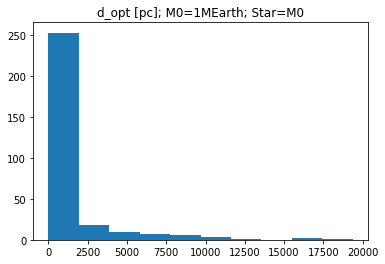

In [11]:
fig, ax = plt.subplots()
ax.set_title("d_opt [pc]; M0=1MEarth; Star=M0")
ax.hist(d_opt)

(array([253.,  18.,   9.,   7.,   6.,   3.,   1.,   0.,   2.,   1.]),
 array([2.19144489e+00, 1.35792469e+03, 2.71365793e+03, 4.06939118e+03,
        5.42512442e+03, 6.78085767e+03, 8.13659091e+03, 9.49232416e+03,
        1.08480574e+04, 1.22037906e+04, 1.35595239e+04]),
 <a list of 10 Patch objects>)

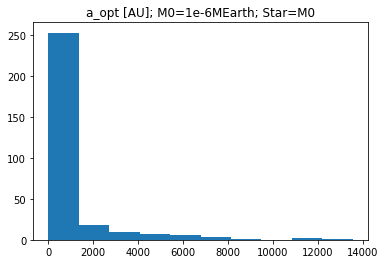

In [12]:
fig, ax = plt.subplots()
ax.set_title("a_opt [AU]; M0=1e-6MEarth; Star=M0")
ax.hist(d_opt*0.7)

(array([83., 67., 22., 24., 15., 21., 21., 14., 21., 12.]),
 array([ 4.45678355,  6.35254049,  8.24829744, 10.14405438, 12.03981132,
        13.93556827, 15.83132521, 17.72708215, 19.6228391 , 21.51859604,
        23.41435298]),
 <a list of 10 Patch objects>)

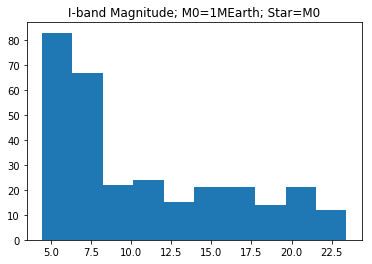

In [13]:
fig, ax = plt.subplots()
ax.set_title("I-band Magnitude; M0=1MEarth; Star=M0")
ax.hist(Imag)

(array([68., 47., 36., 23., 17., 27., 24., 15., 19., 24.]),
 array([20.05503283, 28.04308166, 36.03113049, 44.01917932, 52.00722815,
        59.99527698, 67.98332581, 75.97137464, 83.95942347, 91.9474723 ,
        99.93552113]),
 <a list of 10 Patch objects>)

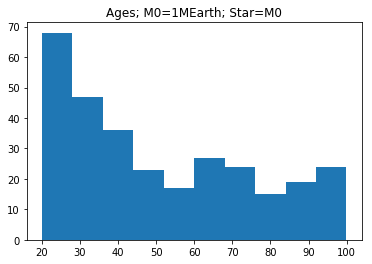

In [14]:
fig, ax = plt.subplots()
ax.set_title("Ages; M0=1MEarth; Star=M0")
ax.hist(ages/Year/1e6)

(array([  0.,   0.,   0.,   0.,   0., 300.,   0.,   0.,   0.,   0.]),
 array([-0.5, -0.4, -0.3, -0.2, -0.1,  0. ,  0.1,  0.2,  0.3,  0.4,  0.5]),
 <a list of 10 Patch objects>)

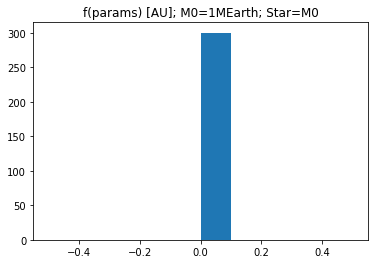

In [15]:
fig, ax = plt.subplots()
ax.set_title("f(params) [AU]; M0=1MEarth; Star=M0")
ax.hist(charAopt/AU)